In [2]:
import pandas as pd
from vitis_algs.data import ExpressionDataset

In [66]:
acc2tissue = {
    "GSE87643":"Petiole", "GSE128865":"Leaf", "GSE202924":"Petiole",
    "GSE58653":"Leaf", "GSE175475":"Callus", "GSE67932":"Berry",
    "GSE116274":"Berry", "GSE76256":"Skin", "GSE85812":"Berry",
    "GSE121146":"Berry", "GSE129046":"Berry", "GSE152164":"Stem",
    "GSE97960":"Berry Pericarp", "GSE129916":"Berry", "GSE103226":"Berry",
    "GSE157347":"Berry", "GSE133761":"Anther/Callus", "GSE97900":"MIXED",  # Leaf + Stem (special-case below)
    "GSE193562":"Leaf", "GSE211268":"Leaf", "GSE77240":"Leaf",
    "GSE182149":"Leaf", "GSE150343":"Berry", "GSE142313":"Berry",
    "GSE127322":"Bud", "GSE206753":"Berry", "GSE62744":"Berry",
    "GSE62745":"Berry", "GSE98923":"Berry", "GSE101532":"Berry",
    "GSE77895":"Berry", "GSE153870":"Berry", "GSE104316":"Berry",
    "GSE153998":"Berry", "GSE168785":"Berry", "GSE223965":"Skin",
}


In [ ]:
import pandas as pd
from vitis_algs.data import ExpressionDataset

expr_path = "../data/preprocessed_log2_standardized_expression.csv"
data = pd.read_csv(expr_path, index_col=0, low_memory=False)
print("Expression shape:", data.shape)

# Build dummy metadata with same index as data
metadata = pd.DataFrame(index=data.index)
metadata["dummy_label"] = "unknown"

# Build ExpressionDataset (genes x samples)
counts_df = data.T  # genes x samples

dataset = ExpressionDataset(
    counts_df=counts_df,
    metadata_df=metadata,
    label_col="dummy_label",
)

x0, y0 = dataset[0]
print("First sample feature shape:", x0.shape)
print("First sample label idx:", y0.item())
print("Label categories:", dataset.label_categories)


Expression shape: (767, 24745)
First sample feature shape: torch.Size([24745])
First sample label idx: 0
Label categories: ['unknown']


In [7]:
import torch
import numpy as np

# Check dataset tensor (already torch from ExpressionDataset)
print("any NaN in X?", torch.isnan(dataset.X).any().item())
print("any Inf in X?", torch.isinf(dataset.X).any().item())

# If any, sanitize (and clip extreme z-scores just in case)
X = torch.nan_to_num(dataset.X, nan=0.0, posinf=0.0, neginf=0.0)
X = torch.clamp(X, -8.0, 8.0)   # 8 SDs is plenty
dataset.X = X


any NaN in X? False
any Inf in X? False


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_genes = dataset[0][0].numel()
latent_dim = 8
hidden = [2048,512]

class VAE(nn.Module):

    def __init__(self, in_dim, latent_dim, hidden):

        super().__init__()

        enc, last = [], in_dim
        for h in hidden:
            enc += [nn.Linear(last, h), nn.ReLU()]
            last = h

        self.enc = nn.Sequential(*enc)
        self.mu = nn.Linear(last, latent_dim)
        self._raw_logvar = nn.Linear(last, latent_dim)

        dec, last = [], latent_dim
        for h in reversed(hidden):
            dec += [nn.Linear(last, h), nn.ReLU()]
            last = h

        dec += [nn.Linear(last, in_dim)]
        self.dec = nn.Sequential(*dec)


    def encode(self, x):

        h = self.enc(x)
        mu = self.mu(h)

        logvar = self._raw_logvar(h)
        logvar = torch.clamp(logvar, -8.0, 8.0)

        return mu, logvar
    

    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return mu + eps * std
    

    def decode(self, z):

        return self.dec(z)
    

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)

        return x_hat, mu, logvar

def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    recon = nn.functional.mse_loss(x_hat, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=False)
model = VAE(n_genes, latent_dim, hidden).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# train
epochs = 100
warmup_steps = 200
target_beta = 0.2
global_step = 0
best = 1e9
patience, bad = 15, 0

for epoch in range(1, epochs+1):
    model.train()
    total=recon_total=kl_total=0.0
    for xb, _ in loader:
        xb = xb.to(device)

        if torch.isnan(xb).any() or torch.isinf(xb).any():
            xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0)
            xb = torch.clamp(xb, -8.0, 8.0)

        x_hat, mu, logvar = model(xb)

        beta = min(target_beta, target_beta * (global_step / max(1, warmup_steps)))
        loss, recon, kl = vae_loss(xb, x_hat, mu, logvar, beta=beta)

        if not torch.isfinite(loss):
            
            for g in opt.param_groups:
                g["lr"] = max(g["lr"] * 0.5, 1e-5)
            continue

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        b = xb.size(0)
        total += loss.item() * b
        recon_total += recon.item() * b
        kl_total += kl.item() * b
        global_step += 1

    n = len(dataset)
    avg, avg_recon, avg_kl = total/n, recon_total/n, kl_total/n
    print(f"epoch {epoch:02d} | loss {avg:.4f} | recon {avg_recon:.4f} | kl {avg_kl:.4f} | beta {beta:.3f}")

    if avg < best - 1e-4:
        best, bad = avg, 0
        torch.save(model.state_dict(), "vae_best.pt")
    else:
        bad += 1
        if bad >= patience:
            print("early stopping"); break


epoch 01 | loss 0.9346 | recon 0.8439 | kl 18.1409 | beta 0.011
epoch 02 | loss 0.8298 | recon 0.6869 | kl 8.5211 | beta 0.023
epoch 03 | loss 0.6564 | recon 0.5233 | kl 4.6970 | beta 0.035
epoch 04 | loss 0.5564 | recon 0.4714 | kl 2.0707 | beta 0.047
epoch 05 | loss 0.5483 | recon 0.4620 | kl 1.6150 | beta 0.059
epoch 06 | loss 0.6514 | recon 0.5180 | kl 1.9986 | beta 0.071
epoch 07 | loss 0.6933 | recon 0.5090 | kl 2.4099 | beta 0.083
epoch 08 | loss 0.5327 | recon 0.4211 | kl 1.2522 | beta 0.095
epoch 09 | loss 0.4983 | recon 0.3815 | kl 1.1559 | beta 0.107
epoch 10 | loss 0.5010 | recon 0.3867 | kl 1.0076 | beta 0.119
epoch 11 | loss 0.5053 | recon 0.3796 | kl 1.0031 | beta 0.131
epoch 12 | loss 0.4798 | recon 0.3571 | kl 0.8915 | beta 0.143
epoch 13 | loss 0.4904 | recon 0.3650 | kl 0.8389 | beta 0.155
epoch 14 | loss 0.4768 | recon 0.3457 | kl 0.8118 | beta 0.167
epoch 15 | loss 0.4770 | recon 0.3451 | kl 0.7601 | beta 0.179
epoch 16 | loss 0.4829 | recon 0.3493 | kl 0.7200 | be

In [ ]:
import torch, pandas as pd

model.load_state_dict(torch.load("vae_best.pt", map_location=device))
model.eval()

Z, ids = [], dataset.sample_ids

with torch.no_grad():

    for i in range(0, len(dataset), 256):

        xb = torch.stack([dataset[j][0] for j in range(i, min(i+256, len(dataset)))])
        mu, _ = model.encode(xb.to(device))
        Z.append(mu.cpu())
        
Z = torch.cat(Z).numpy()

latent_df = pd.DataFrame(Z, index=ids, columns=[f"z{i+1}" for i in range(Z.shape[1])])
latent_df.to_csv("latent_mu.csv")


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
from skbio import DistanceMatrix, TreeNode
from skbio.tree import nj

latent = pd.read_csv("latent_mu.csv", index_col=0)
D = cosine_distances(latent.values)
dm = DistanceMatrix(D, ids=latent.index.astype(str))
tree: TreeNode = nj(dm)

with open("latent_tree.nwk", "w") as f:
    tree.write(f)

/tmp/ipykernel_705746/2836422579.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method="average")


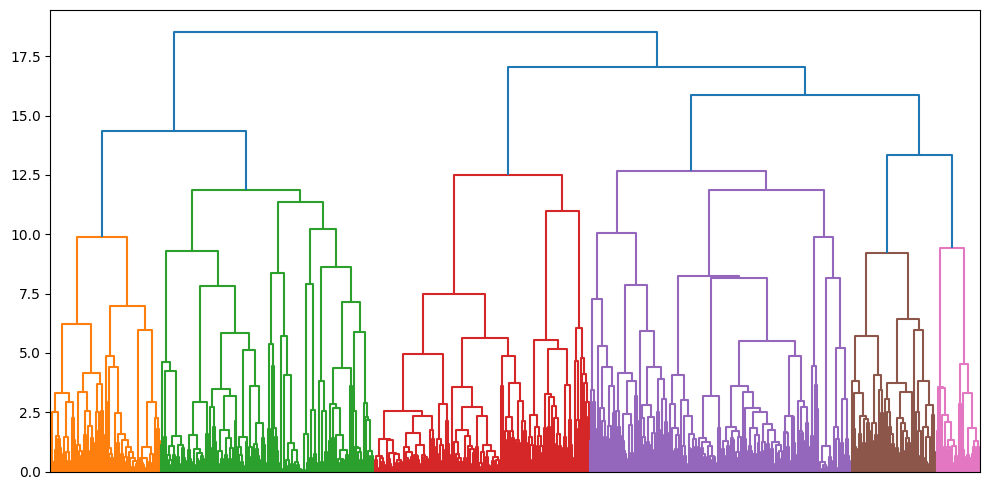

In [60]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(D, method="average")
plt.figure(figsize= (10,5)); dendrogram(Z, labels=latent.index.astype(str), no_labels=True); plt.tight_layout(); plt.show()

/home/null/.pyenv/versions/vitis/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


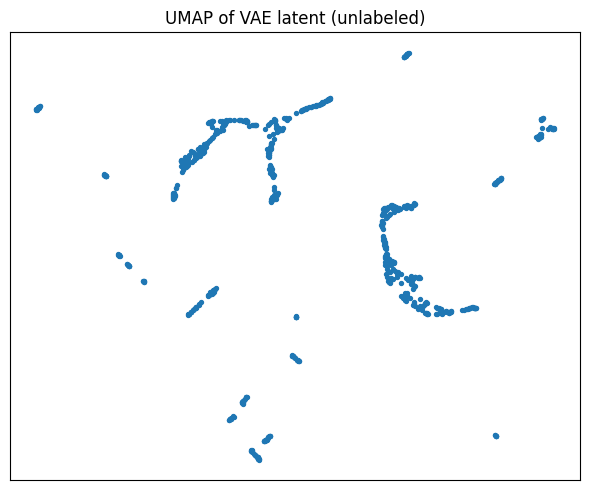

In [ ]:
import umap
import matplotlib.pyplot as plt

latent = pd.read_csv("latent_mu.csv", index_col=0)
emb = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.2, random_state=42).fit_transform(latent.values)

plt.figure(figsize=(6,5))
plt.scatter(emb[:,0], emb[:,1], s=8)
plt.title("UMAP of VAE latent (unlabeled)")
plt.xticks([]); plt.yticks([]); plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

cands = [4,6,8,10,12]
scores = {k: silhouette_score(latent.values, KMeans(k, n_init=20, random_state=42).fit_predict(latent.values), metric="cosine") for k in cands}
print(scores)

{4: 0.43041944757005524, 6: 0.48513913008645465, 8: 0.4994692725205528, 10: 0.5435089132359613, 12: 0.516467651447329}


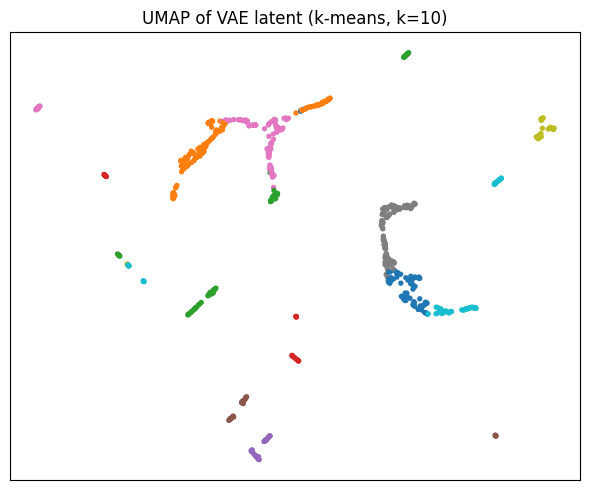

In [ ]:
k = 10
km = KMeans(n_clusters=k, n_init=20, random_state=42)
clusters = km.fit_predict(latent.values)

plt.figure(figsize=(6,5))
plt.scatter(emb[:,0], emb[:,1], s=8, c=clusters, cmap="tab10")
plt.title(f"UMAP of VAE latent (k-means, k={k})")
plt.xticks([]); plt.yticks([]); plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import squareform

X = latent.values
D = cosine_distances(X)
Z = linkage(squareform(D, checks=False), method="average")

coph, _ = cophenet(Z, squareform(D, checks=False))

print("Cophenetic correlation:", round(coph, 3))


Cophenetic correlation: 0.706


/tmp/ipykernel_705746/3808589767.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", k)


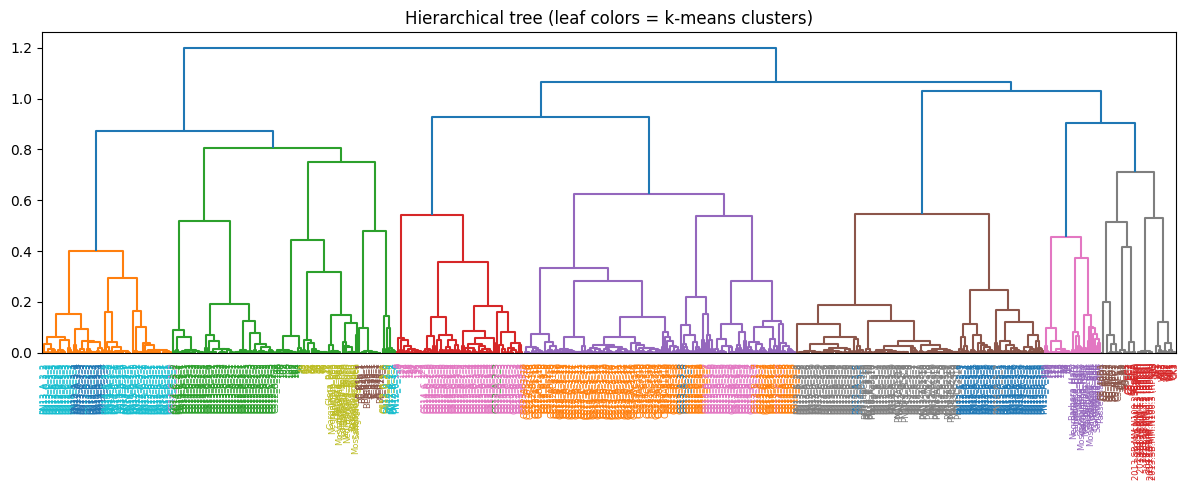

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from matplotlib.colors import to_hex

latent = pd.read_csv("latent_mu.csv", index_col=0)
X = latent.values
k = 10
clusters = KMeans(k, n_init=50, random_state=42).fit_predict(X)

cmap = plt.cm.get_cmap("tab10", k)
colors = [to_hex(cmap(i)) for i in range(k)]
label2color = {i: colors[i] for i in range(k)}

sample_ids = latent.index.astype(str).tolist()
sample2color = {sid: label2color[c] for sid, c in zip(sample_ids, clusters)}

D = cosine_distances(X)
Z = linkage(squareform(D, checks=False), method="average")

def leaf_color_func(id_):
    return "black"

fig, ax = plt.subplots(figsize=(12, 5))
dendro = dendrogram(Z, labels=sample_ids, leaf_rotation=90, leaf_font_size=6, ax=ax)

for lbl in ax.get_xmajorticklabels():
    sid = lbl.get_text()
    lbl.set_color(sample2color.get(sid, "black"))

plt.title("Hierarchical tree (leaf colors = k-means clusters)")
plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#Load latent and metadata
print("Loading latent_mu.csv ...")
latent = pd.read_csv("latent_mu.csv", index_col=0)
print("Latent shape:", latent.shape)

print("Loading sample_metadata.csv ...")
meta = pd.read_csv("../data/sample_metadata.csv", low_memory=False)
print("Metadata rows:", len(meta))

n_latent = latent.shape[0]
if len(meta) < n_latent:
    raise ValueError(f"Metadata has fewer rows ({len(meta)}) than latent samples ({n_latent}).")

meta_used = meta.iloc[:n_latent].copy()
meta_used.index = latent.index


# Label berry vs non-berry
meta_used_str = meta_used.astype(str).apply(lambda col: col.str.lower())
berry_mask = meta_used_str.apply(lambda row: row.str.contains("berry").any(), axis=1)
meta_used["berry_label"] = np.where(berry_mask, "berry", "non-berry")

print("\nBerry label counts (aligned to latent):")
print(meta_used["berry_label"].value_counts())


# Save labels
labels_df = meta_used[["berry_label"]].copy()
labels_df.index.name = "sample_id"
labels_df.to_csv("latent_berry_labels.csv")
print("Saved latent_berry_labels.csv")


# Prepare data for classification
X = latent.values
y_str = meta_used["berry_label"].values

le = LabelEncoder()
y = le.fit_transform(y_str)

print("\nClasses:", list(le.classes_))
print("Class counts:", pd.Series(y_str).value_counts().to_dict())


# Train classifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(len(X_train), len(X_test))

print(np.bincount(y_train), np.bincount(y_test))

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

print("\n=== Classification TrainingReport (Berry vs Non-Berry) ===")
print(classification_report(y_train, y_pred, target_names=le.classes_))

print("Confusion matrix Training (rows=true, cols=pred):")
print(confusion_matrix(y_train, y_pred))


y_pred = clf.predict(X_test)

print("\n=== Classification Report Testing (Berry vs Non-Berry) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion matrix Testing (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))


Loading latent_mu.csv ...
Latent shape: (767, 8)
Loading sample_metadata.csv ...
Metadata rows: 859

Berry label counts (aligned to latent):
berry_label
berry        727
non-berry     40
Name: count, dtype: int64
Saved latent_berry_labels.csv

Classes: ['berry', 'non-berry']
Class counts: {'berry': 727, 'non-berry': 40}
613 154
[581  32] [146   8]

=== Classification TrainingReport (Berry vs Non-Berry) ===
              precision    recall  f1-score   support

       berry       1.00      1.00      1.00       581
   non-berry       1.00      1.00      1.00        32

    accuracy                           1.00       613
   macro avg       1.00      1.00      1.00       613
weighted avg       1.00      1.00      1.00       613

Confusion matrix Training (rows=true, cols=pred):
[[581   0]
 [  0  32]]

=== Classification Report Testing (Berry vs Non-Berry) ===
              precision    recall  f1-score   support

       berry       1.00      1.00      1.00       146
   non-berry       1.

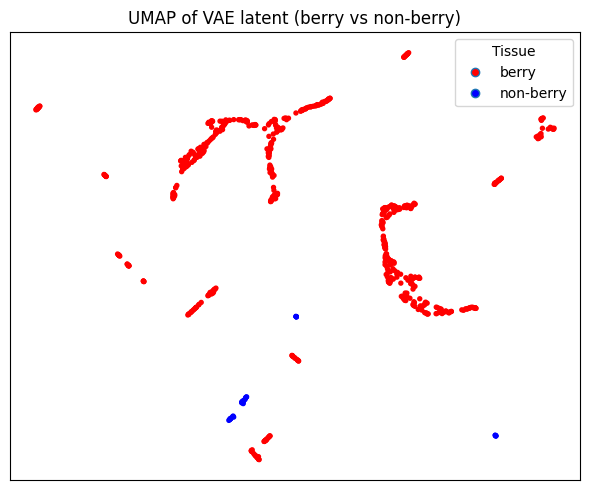

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load labels and align with latent / emb
labels = pd.read_csv("latent_berry_labels.csv", index_col=0)
labels = labels.loc[latent.index]  # make sure same order
y = labels["berry_label"]

# Turn 'berry'/'non-berry' into integers for coloring
codes = y.map({"berry": 1, "non-berry": 0}).astype(int)

# Plot UMAP colored by berry vs non-berry
plt.figure(figsize=(6,5))
sc = plt.scatter(emb[:, 0], emb[:, 1], s=8, c=codes, cmap="bwr")

# Build a small legend
legend_elems = [
    Line2D([0], [0], marker="o", linestyle="None", label="berry",
           markersize=6, markerfacecolor=plt.cm.bwr(1.0)),

    Line2D([0], [0], marker="o", linestyle="None", label="non-berry",
           markersize=6, markerfacecolor=plt.cm.bwr(0.0)),
]

plt.legend(handles=legend_elems, title="Tissue")
plt.title("UMAP of VAE latent (berry vs non-berry)")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()


/tmp/ipykernel_705746/2779192660.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", k)  # same map used everywhere


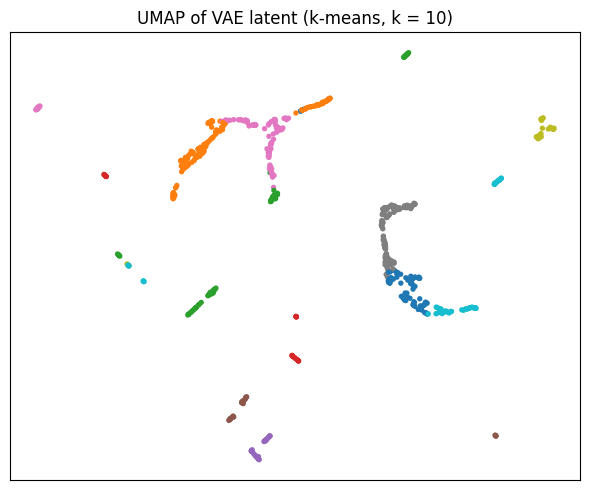

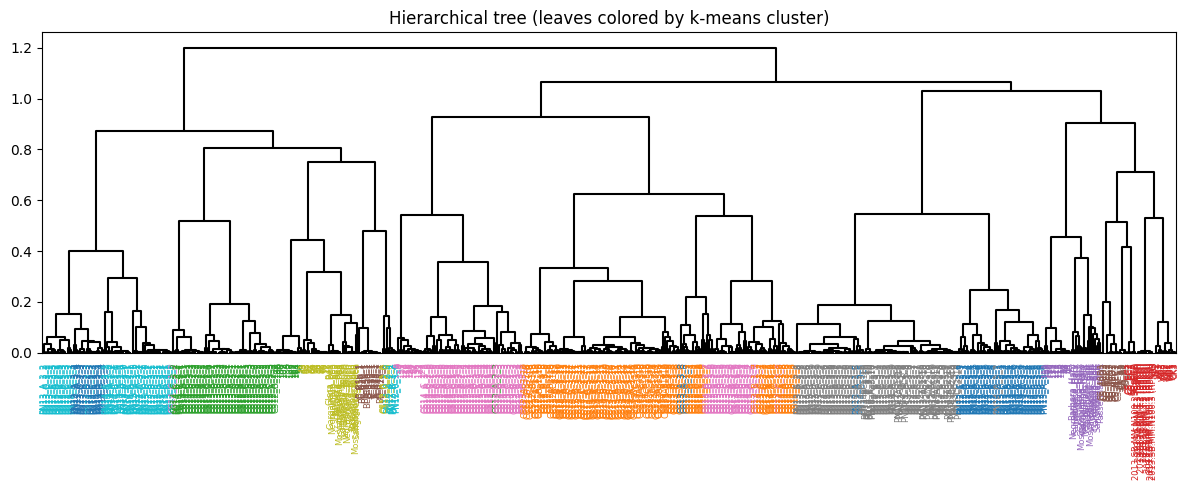

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from matplotlib.colors import to_hex

# Load latent
latent = pd.read_csv("latent_mu.csv", index_col=0)
X = latent.values
sample_ids = latent.index.astype(str).tolist()

# K-means once, shared across plots
k = 10
km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(X)
clusters = km.labels_

# Shared colormap
cmap = plt.cm.get_cmap("tab10", k)
colors = [to_hex(cmap(i)) for i in range(k)]
label2color = {i: colors[i] for i in range(k)}
sample2color = {sid: label2color[c] for sid, c in zip(sample_ids, clusters)}

# UMAP colored by cluster
plt.figure(figsize=(6, 5))
plt.scatter(emb[:, 0], emb[:, 1], s=8, c=clusters, cmap=cmap)
plt.title(f"UMAP of VAE latent (k-means, k = {k})")
plt.xticks([]); plt.yticks([]); plt.tight_layout()
plt.show()

# Tree with leaf colors matching the same clusters
D = cosine_distances(X)
Z = linkage(squareform(D, checks=False), method="average")

fig, ax = plt.subplots(figsize=(12, 5))
dendro = dendrogram(
    Z,
    labels=sample_ids,
    leaf_rotation=90,
    leaf_font_size=6,
    ax=ax,
    color_threshold=0,
    link_color_func=lambda k: "black"
)

# Color tick labels using k-means colors
for lbl in ax.get_xmajorticklabels():

    sid = lbl.get_text()
    lbl.set_color(sample2color.get(sid, "black"))

plt.title("Hierarchical tree (leaves colored by k-means cluster)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform

from skbio import DistanceMatrix
from skbio.tree import nj
from matplotlib.colors import to_hex

# Load latent and run k-means (or reuse existing clusters)
latent = pd.read_csv("latent_mu.csv", index_col=0)
X = latent.values
sample_ids = latent.index.astype(str).tolist()

k = 10
km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(X)
clusters = km.labels_


# Shared colormap (same as your UMAP / dendrogram)
cmap = plt.cm.get_cmap("tab10", k)
label2color = {i: to_hex(cmap(i)) for i in range(k)}
sample2cluster = {sid: c for sid, c in zip(sample_ids, clusters)}
sample2color = {sid: label2color[c] for sid, c in sample2cluster.items()}


# Build a NON-ROOTED Neighbor-Joining tree from cosine distances
D = cosine_distances(X)
dm = DistanceMatrix(D, ids=sample_ids)
tree = nj(dm)


# Save Newick for FigTree/iTOL (not sure if working...)
tree.write("latent_nj_tree.nwk")
print("Wrote unrooted NJ tree to latent_nj_tree.nwk")


# Export cluster colors for iTOL (or similar) so colors match
with open("itol_clusters_colorstrip.txt", "w") as f:

    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR\tTAB\n")
    f.write("DATASET_LABEL\tkmeans_clusters\n")
    f.write("COLOR\t#000000\n\n")

    # Legend
    f.write("LEGEND_TITLE\tk-means clusters\n")
    f.write("LEGEND_SHAPES\t" + "\t".join(["1"] * k) + "\n")
    f.write("LEGEND_COLORS\t" + "\t".join(label2color[i] for i in range(k)) + "\n")
    f.write("LEGEND_LABELS\t" + "\t".join(str(i) for i in range(k)) + "\n\n")

    # Data: one line per leaf
    f.write("DATA\n")
    for sid in sample_ids:
        c = sample2cluster[sid]
        col = label2color[c]
        f.write(f"{sid}\t{col}\t{c}\n")

print("Wrote matching color strip to itol_clusters_colorstrip.txt")

Wrote unrooted NJ tree to latent_nj_tree.nwk
Wrote matching color strip to itol_clusters_colorstrip.txt


/tmp/ipykernel_705746/671382792.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", k)


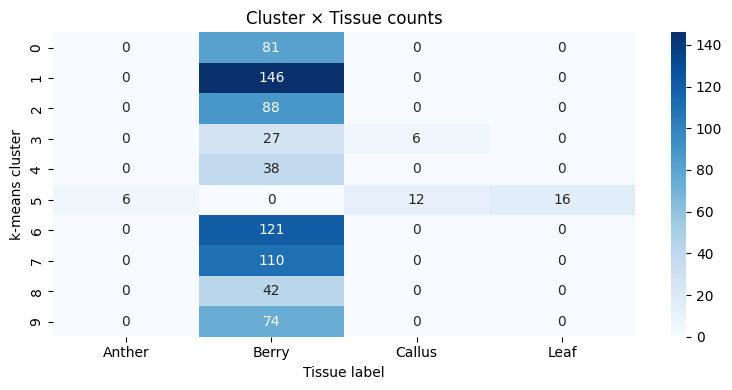

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

clusters = pd.Series(clusters, index=latent.index, name="cluster")
tissue = meta_used["tissue_label"]
tab = pd.crosstab(clusters, tissue)

plt.figure(figsize=(8,4))
sns.heatmap(tab, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster × Tissue counts")
plt.ylabel("k-means cluster")
plt.xlabel("Tissue label")
plt.tight_layout()
plt.show()


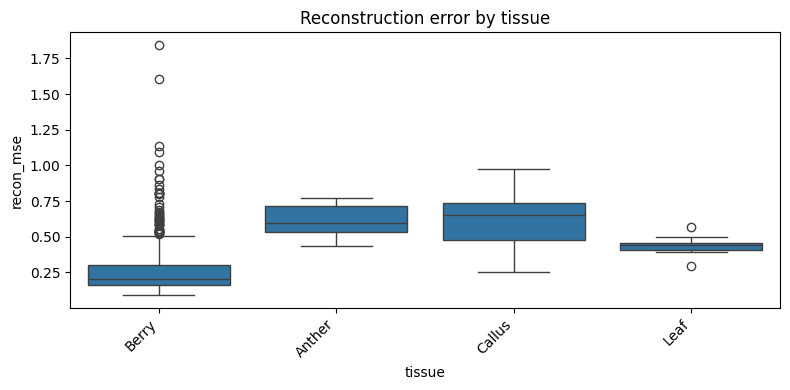

In [ ]:
import torch
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

loader = DataLoader(dataset, batch_size=64, shuffle=False)
model.eval()

recon_mse = []
with torch.no_grad():

    for xb, _ in loader:

        xb = xb.to(next(model.parameters()).device)
        
        xhat, mu, logvar = model(xb)

        mse = ((xhat - xb)**2).mean(dim=1).cpu().numpy()

        recon_mse.extend(mse)

recon_mse = pd.Series(recon_mse, index=latent.index, name="recon_mse")

df_err = pd.DataFrame({
    "recon_mse": recon_mse,
    "tissue": meta_used["tissue_label"],
    "dataset": meta_used["dataset"]
})

plt.figure(figsize=(8,4))
sns.boxplot(data=df_err, x="tissue", y="recon_mse")
plt.xticks(rotation=45, ha="right")
plt.title("Reconstruction error by tissue")
plt.tight_layout()
plt.show()


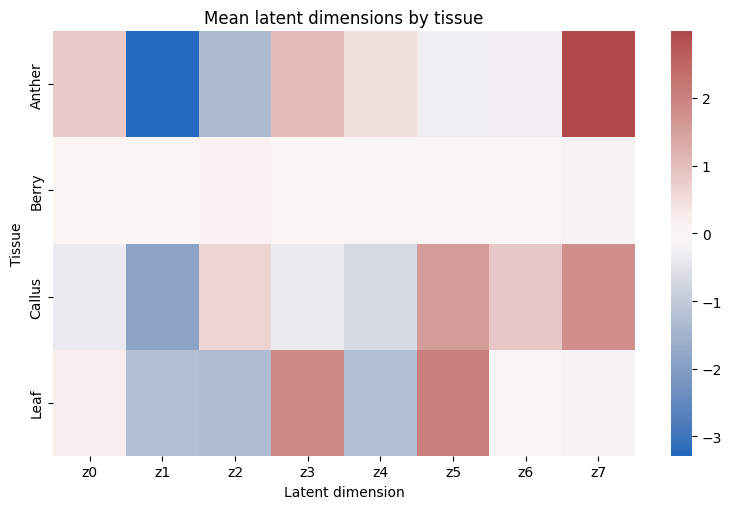

In [96]:
# Mean latent value per tissue and dimension
mean_by_tissue = Z.groupby("tissue")[Z.columns[:-1]].mean()

plt.figure(figsize=(8, 4 + 0.3*mean_by_tissue.shape[0]))
sns.heatmap(mean_by_tissue, cmap="vlag", center=0, annot=False)
plt.title("Mean latent dimensions by tissue")
plt.xlabel("Latent dimension")
plt.ylabel("Tissue")
plt.tight_layout()
plt.show()


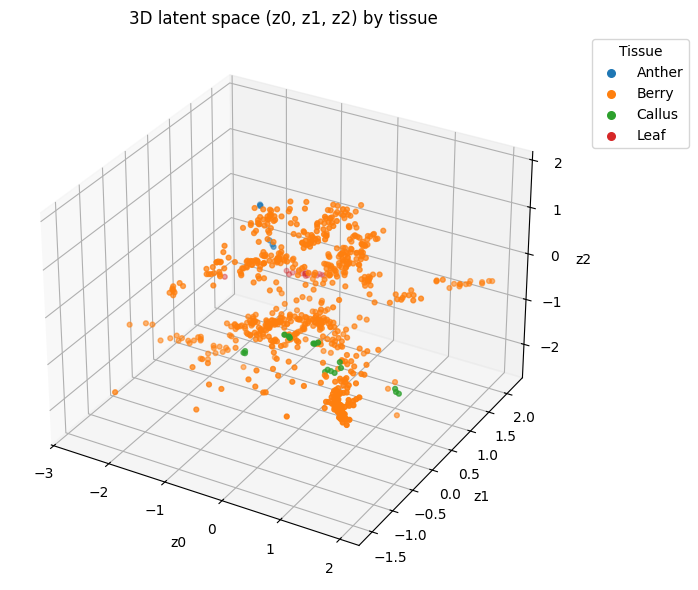

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

tissue = Z["tissue"].astype(str).fillna("Unknown")

# build palette + mapping tissue -> color
unique_tissues = sorted(tissue.unique())
palette = sns.color_palette("tab10", n_colors=len(unique_tissues))
tissue2color = {t: palette[i] for i, t in enumerate(unique_tissues)}

colors = [tissue2color[t] for t in tissue]

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(Z["z2"], Z["z3"], Z["z4"], c=colors, s=12)

ax.set_xlabel("z0")
ax.set_ylabel("z1")
ax.set_zlabel("z2")
ax.set_title("3D latent space (z0, z1, z2) by tissue")

# Legend
for t in unique_tissues:
    ax.scatter([], [], [], c=[tissue2color[t]], label=t, s=30)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Tissue")

plt.tight_layout()
plt.show()


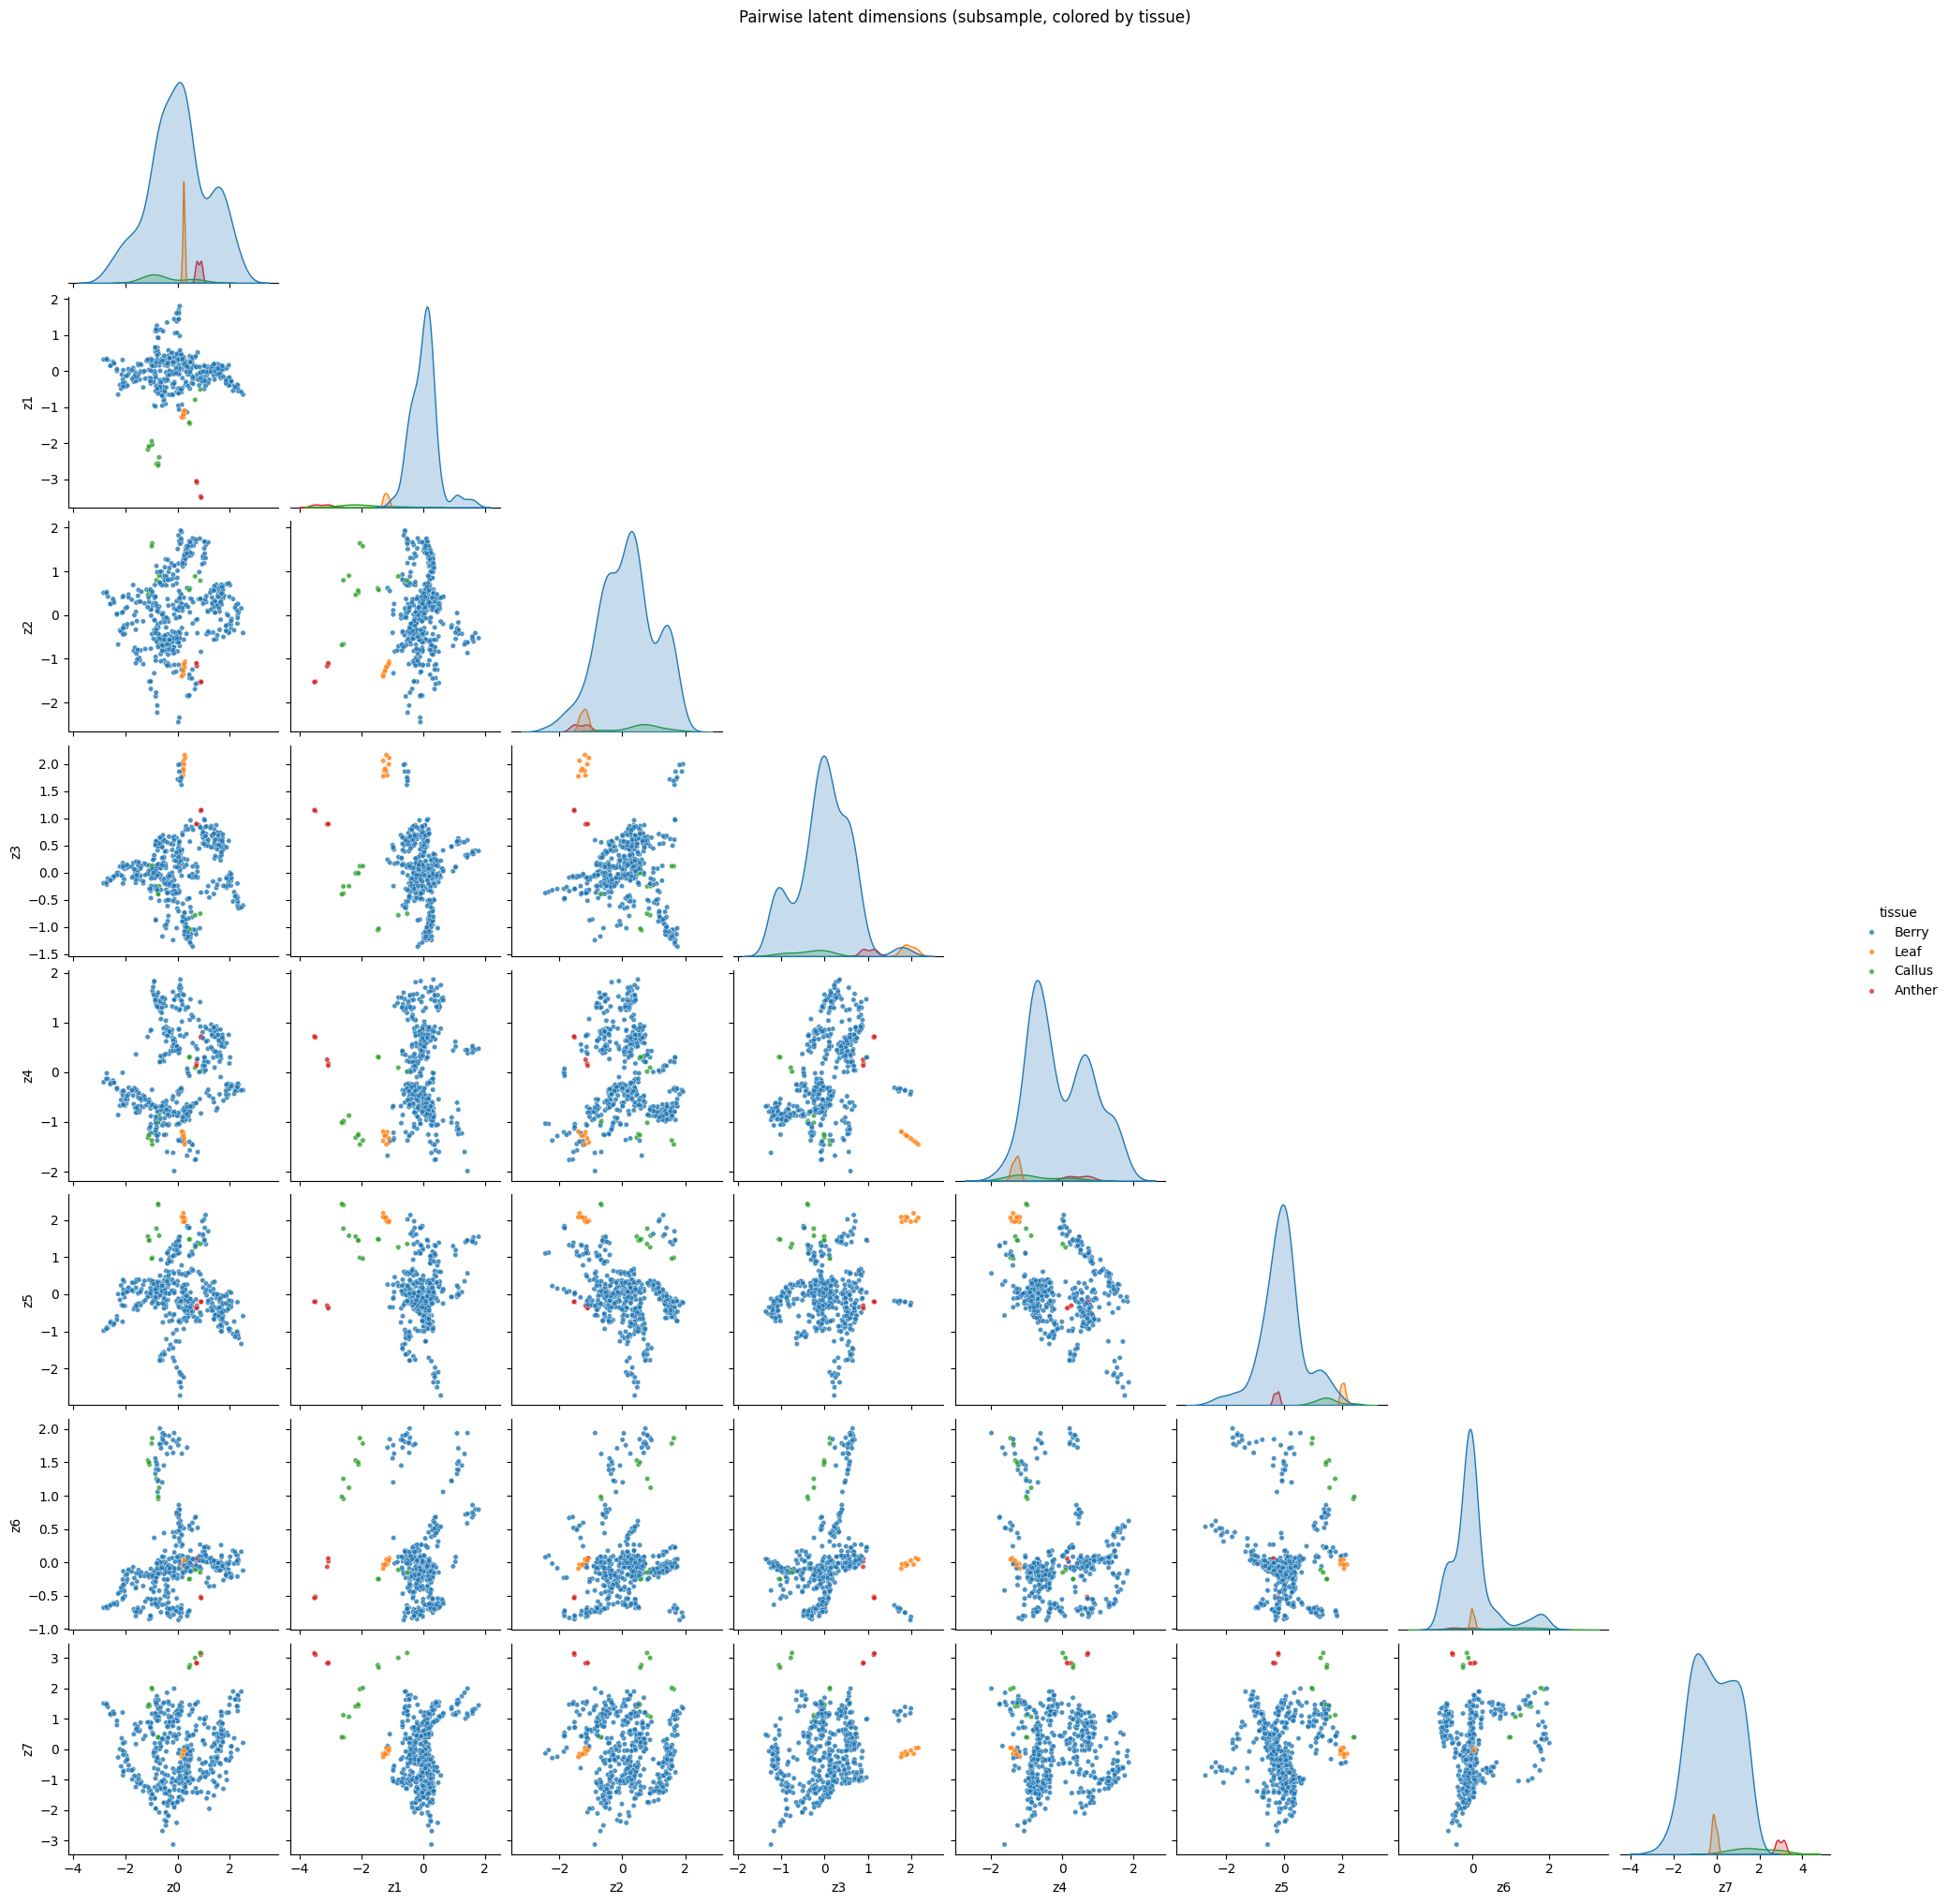

In [ ]:
Z_sub = Z.copy()
if len(Z_sub) > 500:
    Z_sub = Z_sub.sample(500, random_state=42)

sns.pairplot(
    Z_sub,
    vars=[f"z{i}" for i in range(latent.shape[1])],
    hue="tissue",
    corner=True,
    plot_kws={"s": 15, "alpha": 0.8}
)

plt.suptitle("Pairwise latent dimensions (subsample, colored by tissue)", y=1.02)
plt.show()
